# Polynomial regression

## Train-test split

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

data = pd.read_csv('boston.csv')

In [69]:
data.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [70]:
def train_test_split(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_size]
    train_indices = shuffled_indices[test_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [71]:
train_sample, test_sample = train_test_split(data, 0.2)

In [72]:
feature_size = data.shape[1]
train_size = train_sample.shape[0]
Y_train = train_sample['medv']
X_train = train_sample.drop(['medv'], axis = 1)

## Predictor filtering

In [73]:
np.dot(X_train['dis'], Y_train)

35711.11

In [74]:
arr = np.array(X_train['dis'].T)

In [75]:
print(arr.shape)

(405,)


In [76]:
# I avoid using the internal corr function, of course...
def corr_pearson(X, Y):
    corr_pearson = []
    for j in range(X.shape[1]):
        X_temp = X.iloc[:, j] - np.mean(X.iloc[:, j])
        Y_temp = Y - np.mean(Y)
        R_temp = np.dot(X_temp, Y_temp) / np.sqrt(np.dot(X_temp, X_temp) * np.dot(Y_temp, Y_temp))
        corr_pearson.append(R_temp)
    return corr_pearson
    

In [77]:
corr_pearson(X_train, Y_train)

[-0.3866061880418384,
 0.3319732484832603,
 -0.4772954269660901,
 0.20907035820298103,
 -0.4122052105658948,
 0.6990405928112161,
 -0.33850420029113315,
 0.23311969302682053,
 -0.3678958750032135,
 -0.4652127679280996,
 -0.4955418073104065,
 0.3210484120246252,
 -0.7380583118051509]

In [78]:
absolute_values = [abs(number) for number in corr_pearson(X_train, Y_train)]

In [79]:
best_2_indices = np.argsort(absolute_values, axis=0)[-2:]

In [80]:
best_2_names = data.columns[best_2_indices]

In [81]:
import itertools as it

In [82]:
def corr_pearson_matrix(X):
    corr_pearson_matrix = np.ones((X.shape[1], X.shape[1]))
    for j, k in it.permutations(range(X.shape[1]), 2):
        X_j_temp = X.iloc[:, j] - np.mean(X.iloc[:, j])
        X_k_temp = X.iloc[:, k] - np.mean(X.iloc[:, k])
        R_temp = np.dot(X_j_temp, X_k_temp) / np.sqrt(np.dot(X_j_temp, X_j_temp) * np.dot(X_k_temp, X_k_temp))
        corr_pearson_matrix[j, k] = R_temp
    return corr_pearson_matrix

In [83]:
corr_train_matrix = corr_pearson_matrix(train_sample)

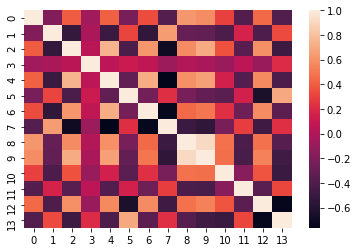

In [84]:
import seaborn as sns

corr_heatmap = sns.heatmap(corr_train_matrix)

In [85]:
# Looking at the last column of the heatmap, we choose two that are either the darkest or the brightest--5 and 12. 

In [86]:
# If we observe the rest, I would say that (8, 9) is suspected to be linearly dependent. 
# Let me print out their values.

In [87]:
corr_train_matrix[8, 9]

0.914112402277257

##  Multiple regression model based on X1 and X2

In [88]:
regressors_ind = best_2_names
explained_var_ind = "medv"

In [89]:
def feature_normalize(df, mu=None, sigma=None):
    # copy the dataframe
    if df.size == 0:
        return df, None, None
    df_normalized = df.copy()
    if mu is None and sigma is None:
        mu = df_normalized.mean(axis=0)
        sigma = df_normalized.std(axis=0, ddof=1)
    df_normalized = (df_normalized - mu) / sigma
    return df_normalized, mu, sigma

In [90]:
X = train_sample[regressors_ind]

X_norm = feature_normalize(X)[0]
mu = feature_normalize(X)[1]
sigma = feature_normalize(X)[2]

X_train = X_norm.copy()

n, d = X_train.shape
X_train.insert(0, "Ones", np.ones((n, 1)))
X_train

,Ones,rm,lstat
491,1.0,-0.409472,0.738269
213,1.0,0.122803,-0.464203
114,1.0,-0.041496,-0.316142
68,1.0,-0.937673,0.049166
60,1.0,-0.738070,0.057468
...,...,...,...
222,1.0,0.807156,-0.388097
313,1.0,-0.025202,-0.668997
230,1.0,-0.412188,-0.150093
23,1.0,-0.640305,0.988727


In [91]:
Y_train = pd.DataFrame(train_sample[explained_var_ind])
Y_train

,medv
491,13.6
213,28.1
114,18.5
68,17.4
60,18.7
...,...
222,27.5
313,21.6
230,24.3
23,14.5


In [92]:
covXX = X_train.T.dot(X_train)
eigs_covXX = np.linalg.eig(covXX)[0]
cond_num_covXX = max(abs(eigs_covXX)) / min(abs(eigs_covXX))
display(eigs_covXX)
display(cond_num_covXX)

array([405.        , 661.57950093, 146.42049907])

4.518352997908681

In [93]:
beta_OLS_explicit_rm_lstat = np.linalg.inv(covXX).dot(X_train.T).dot(Y_train)
beta_OLS_explicit_rm_lstat

array([[22.62617284],
       [ 3.65697896],
       [-4.67967655]])

In [94]:
from sklearn import linear_model

regr = linear_model.LinearRegression()
regr.fit(X_norm, Y_train)
beta_OLS_water_ca = regr.intercept_, regr.coef_
display(beta_OLS_water_ca)
display(Y_train.mean())

(array([22.62617284]), array([[ 3.65697896, -4.67967655]]))

medv    22.626173
dtype: float64

In [95]:
Y_hat_train = X_train.dot(beta_OLS_explicit_rm_lstat)
Y_hat_train

,0
491,17.673881
213,25.247579
114,23.953866
68,18.967043
60,19.658134
...,...
222,27.394094
313,25.664697
230,21.821199
23,15.657668


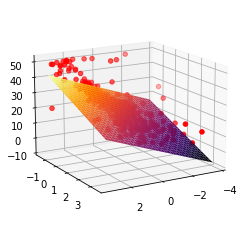

In [96]:
X1 = np.arange(min(X_train["rm"]), max(X_train["rm"]), 0.1)
X2 = np.arange(min(X_train["lstat"]), max(X_train["lstat"]), 0.1)
X1, X2 = np.meshgrid(X1, X2)
Z = beta_OLS_explicit_rm_lstat[0] + X1 * beta_OLS_explicit_rm_lstat[1] + X2 * beta_OLS_explicit_rm_lstat[2]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_norm["rm"], X_norm["lstat"], Y_train, color='red')
ax.plot_surface(X1, X2, Z, cmap='inferno')
ax.view_init(15, 60)
plt.show()

In [97]:
def loss_l2(Y_hat, Y):
    loss = np.mean(np.power(np.array(Y_hat) - np.array(Y), 2))
    return loss

In [98]:
loss_l2_train = loss_l2(Y_hat_train, Y_train)
loss_l2_train

33.06573195535589

In [99]:
X_test = test_sample[regressors_ind]

X_test_norm = feature_normalize(X_test, mu, sigma)[0]

X_test = X_test_norm.copy()
n, d = X_test.shape
X_test.insert(0, "Ones", np.ones((n, 1)))
X_test

Y_hat_test = X_test.dot(beta_OLS_explicit_rm_lstat)
Y_test= pd.DataFrame(test_sample[explained_var_ind])

loss_l2_test = loss_l2(Y_hat_test, Y_test)
loss_l2_test

20.40920807754238

## Polynomial regression models based on X1 and X2 

In [100]:
X_train.drop('Ones', axis = 1, inplace=True)

In [101]:
X_train = np.array(X_train)

In [102]:
Y_train = np.array(Y_train)

In [103]:
X_test.drop('Ones', axis = 1, inplace=True)
X_test = np.array(X_test)
Y_test = np.array(Y_test)

In [104]:
class PolynomialRegression():
    def __init__(self):
        self.coefficients = None
        self.mu = None
        self.sigma = None
    
    def fit(self, X_train, Y_train, order):
        n_train = X_train.shape[0]
        V_train = np.ones((n_train, 1))

        for i in range(order):
            V_train = np.concatenate((V_train, X_train ** (i + 1)), axis = 1)

        normalized, self.mu, self.sigma = feature_normalize(V_train[:,1:])
        V_train = np.c_[V_train[:,0], normalized]

        self.coefficients = np.linalg.pinv(V_train.T.dot(V_train)).dot(V_train.T.dot(Y_train))
        
        Y_train_hat = V_train.dot(self.coefficients).ravel()
        mse_train = (np.square(Y_train_hat - Y_train.ravel())).mean()

        return self
    
    def predict(self, X_test):
        n_test = X_test.shape[0]
        d_test = X_test.shape[1]
        V_test = np.ones((n_test, 1))
        order = int((len(self.coefficients) - 1) / d_test)
        
        for i in range(order):
            V_test = np.concatenate((V_test, X_test ** (i + 1)), axis = 1)

        normalized, _, _ = feature_normalize(V_test[:,1:], self.mu, self.sigma)
        V_test = np.c_[V_test[:,0], normalized]
        
        Y_test_hat = V_test.dot(self.coefficients)

        return Y_test_hat
    
    def score(self, X, Y):
        Y_hat = self.predict(X)
        return (np.square(Y_hat.ravel() - Y.ravel())).mean()
    

k = 6
yh = np.zeros((len(X_train), k))
score = np.zeros((1, k))
for order in range(k):
    pr = PolynomialRegression().fit(X_train, Y_train, order)
    yh[:, order] = pr.predict(X_train).ravel()
    score[:, order] = pr.score(X_train, Y_train).ravel()

In [105]:
print(score)

[[90.01980881 33.06573196 23.30487814 23.15050349 21.1012055  20.02130886]]


## Cross validation

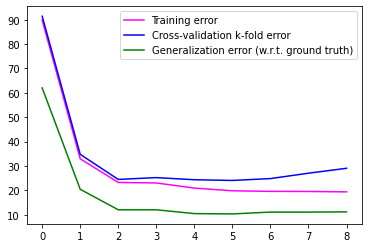

In [106]:
import math

k = 9
n_train = X_train.shape[0]
n_test = X_test.shape[0]

#k-fold cross-validation
num_fold = 8
n_fold = math.floor(n_train / num_fold)

MSE_train_fold = np.zeros((k, num_fold))
CV_MSE_fold = np.zeros((k, num_fold))
MSE_train = np.zeros((k, 1))
CV_MSE = np.zeros((k, 1))
Y_test_hat = np.zeros((n_test, k))
MSE_test = np.zeros((k, 1))

for order in range(k):
    Y_train_hat = np.zeros((n_train - n_fold, num_fold))
    Y_train_hat_fold = np.zeros((n_fold, num_fold))
    X_train_hat = []
    for cur_fold in range(num_fold):
        X_fold = X_train[cur_fold * n_fold:(cur_fold + 1) * n_fold]
        Y_fold = Y_train[cur_fold * n_fold:(cur_fold + 1) * n_fold]
        X_train_fold = X_train[np.r_[0:cur_fold * n_fold, (cur_fold + 1) * n_fold:n_train]]
        Y_train_fold = Y_train[np.r_[0:cur_fold * n_fold, (cur_fold + 1) * n_fold:n_train]]
        
        pr = PolynomialRegression().fit(X_train_fold, Y_train_fold, order)
        MSE_train_fold[order, cur_fold] = pr.score(X_train_fold, Y_train_fold)
        CV_MSE_fold[order, cur_fold] = pr.score(X_fold, Y_fold)

    CV_MSE[order] = CV_MSE_fold[order,:].mean()
    MSE_train[order] = MSE_train_fold[order, :].mean()
    
    pr = PolynomialRegression().fit(X_train, Y_train, order)
    MSE_test[order] = pr.score(X_test, Y_test)

plt.plot(MSE_train, color="magenta")
plt.plot(CV_MSE, color="blue")
plt.plot(MSE_test, color='green')
plt.legend(('Training error','Cross-validation k-fold error', 'Generalization error (w.r.t. ground truth)'))
plt.show()